<a href="https://colab.research.google.com/github/CS7140/PA-4/blob/main/Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rajesh Sakhamuru
# **Linear Regression using Boston Housing Data dataset**
Gradient Descent with and without regularization

housing.csv is in the 'datasets' folder of the repository. Please change the file path accordingly.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
import math

In [3]:
# data visualization options for console output
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)

In [4]:
def getColNames(data):
    '''
    Returns list of column names of data given
    :param data: pandas dataframe
    '''
    return list(data.columns)

In [5]:
def calculateSSE(data, target, weightsMatrix):
    '''
    After gradient descent, this function can be used to determine 
    the SSE indicating how much error the model has over the data and its 
    predictions.
     
    :param testData: testing data dataframe object
    :param target: target column name
    '''

    targetCol = data[target].values.tolist()

    testData = data.drop(columns=[target])
    testRowsList = testData.values.tolist()
    SSE = 0

    # calculate squared errors for each row in testing data and sum them for the SSE
    for n in range(len(testRowsList)):
        row = testRowsList[n]
        row = np.array(row)

        prediction = float(np.sum((weightsMatrix.T * row)))
        actual = float(targetCol[n])
#         print(row, "\nprediction:", prediction, "actual:", actual, "  ")

        SSE += (prediction - actual) * (prediction - actual)

    return SSE

In [6]:
def calculateRSqrd(data, target, weightsMatrix):
    '''
    This function can be used to determine 
    the R-squared indicating the variability of the data around the model.
     
    :param testData: testing data dataframe object
    :param target: target column name
    :param weightsMatrix: linear model weights
    '''

    targetCol = data[target].values.tolist()
    y_mean = np.mean(targetCol)

    testData = data.drop(columns=[target])
    testRowsList = testData.values.tolist()
    SSE = 0
    totalSumSq = 0
    # calculate squared errors for each row in testing data and sum them for the SSE
    for n in range(len(testRowsList)):
        row = testRowsList[n]
        row = np.array(row)

        prediction = float(np.sum((weightsMatrix.T * row)))
        actual = float(targetCol[n])
#         print(row, "\nprediction:", prediction, "actual:", actual, "  ")
        totalSumSq += (actual - y_mean) ** 2
        SSE += (prediction - actual) * (prediction - actual)

    rSquared = 1 - (SSE/totalSumSq)

    return rSquared

In [7]:
def zScoreNormalization(originalData, target, normParams=None):
    '''
    z-score normalization of features in data parameter. If mean and standard
    deviation are provided for each feature in normParams, then those are used to
    normalize the data.
    
    :param originalData: pandas dataframe
    :param target: target column name
    :param normParams: list of (mean, stdDev) tuples for each feature
    '''

    data = originalData.copy()

    colNames = getColNames(data)

    if target in colNames:
        colNames.remove(target)

    testing = False

    minMaxParams = []

    # if using given normalization parameters to normalize data
    if normParams is None:
        normParams = []
    else:
        testing = True

    count = 0

    for col in colNames:
        if col == '0':
            normParams.append((1, 0))
            count += 1
            continue
        # min and max feature values for feature re-scaling if wanted
        minMaxParams.append((data[col].min(), data[col].max()))

        if len(data[col].unique()) == 1:
            # data[col] = 0
            data[col] = 1

            if not testing:
                normParams.append((0, 0))

            count += 1
            continue
        if not testing:
            mean = data[col].mean()
            stdDev = st.pstdev(list(data[col]))
            normParams.append((mean, stdDev))
        else:
            mean, stdDev = normParams[count]

        data[col] = data[col] - mean
        data[col] = round(data[col] / stdDev, 3)

        count += 1

    return data, normParams, minMaxParams

In [8]:
def gradientDescent(originalData, target, learningRate, tolerance):
    '''
    Calculates the weights to assign to features using gradient descent. Also
    returns RMSE list of each RMSE per iteration and R-squared values.
    
    :param originalData: pandas dataframe data
    :param target: target column name
    :param learningRate: learning rate to limit gradient descent jumps
    :param tolerance: tolerence threshold to determine when gradient descent
                        has converged
    '''

    data = originalData.copy()

    colNames = getColNames(data)

    featList = colNames.copy()
    if target in colNames:
        featList.remove(target)

    weights = [[0]] * len(featList)

    weightsMatrix = np.array(weights)

    targetCol = data[target].values.tolist()
    targetMatrix = np.array([[n] for n in targetCol])

    dataMatrix = np.array(data.drop(columns=[target]))

    converged = False

    count = 0

    SSE = calculateSSE(data, target, weightsMatrix)
    rSqr = calculateRSqrd(data, target, weightsMatrix)
    priorRMSE = math.sqrt(SSE / len(data))
    RMSEList = [priorRMSE]
    rSqrList = [rSqr]

    while not converged:
        # calculate gradient
        gradient = []
        for feat in range(len(featList)):
            featGrad = 0

            for i in range(len(dataMatrix)):
                featGrad += ((weightsMatrix.T.dot(dataMatrix[i])) - targetMatrix[i]) * dataMatrix[i][feat]
            gradient.append(featGrad)

        gradient = np.array(gradient)

        newWeights = (weightsMatrix - (learningRate * (gradient)))
        weightsMatrix = newWeights

        SSE = calculateSSE(data, target, weightsMatrix)
        rSqr = calculateRSqrd(data, target, weightsMatrix)

        currentRMSE = math.sqrt(SSE / len(data))

        if (abs(priorRMSE - currentRMSE) < tolerance):
            converged = True

        priorRMSE = currentRMSE
        RMSEList.append(priorRMSE)
        rSqrList.append(rSqr)

        count += 1
        if count >= 1000:
            converged = True

    return weightsMatrix, RMSEList, rSqrList

In [9]:
def gradientDescentRegularized(originalData, target, learningRate, tolerance):
    '''
    Calculates the weights to assign to features using gradient descent. Also
    returns RMSE list of each RMSE per iteration and R-squared values.
    
    :param originalData: pandas dataframe data
    :param target: target column name
    :param learningRate: learning rate to limit gradient descent jumps
    :param tolerance: tolerence threshold to determine when gradient descent
                        has converged
    '''

    data = originalData.copy()

    colNames = getColNames(data)

    featList = colNames.copy()
    if target in colNames:
        featList.remove(target)

    weights = [[0]] * len(featList)

    weightsMatrix = np.array(weights)

    targetCol = data[target].values.tolist()
    targetMatrix = np.array([[n] for n in targetCol])

    dataMatrix = np.array(data.drop(columns=[target]))

    converged = False

    count = 0

    SSE = calculateSSE(data, target, weightsMatrix)
    rSqr = calculateRSqrd(data, target, weightsMatrix)
    priorRMSE = math.sqrt(SSE / len(data))
    RMSEList = [priorRMSE]
    rSqrList = [rSqr]

    while not converged:
        # calculate gradient
        gradient = []
        for feat in range(len(featList)):
            featGrad = 0

            for i in range(len(dataMatrix)):
                featGrad += ((weightsMatrix.T.dot(dataMatrix[i])) - targetMatrix[i]) * dataMatrix[i][feat]
            gradient.append(featGrad)

        gradient = np.array(gradient)

        # Regularize weights during gradient descent
        lambdaVar = 1/2
        regularization = 2 * lambdaVar * weightsMatrix

        newWeights = (weightsMatrix - (learningRate * (gradient + regularization)))
        weightsMatrix = newWeights

        SSE = calculateSSE(data, target, weightsMatrix)
        rSqr = calculateRSqrd(data, target, weightsMatrix)

        currentRMSE = math.sqrt(SSE / len(data))

        if (abs(priorRMSE - currentRMSE) < tolerance):
            converged = True

        priorRMSE = currentRMSE
        RMSEList.append(priorRMSE)
        rSqrList.append(rSqr)

        count += 1
        if count >= 1000:
            converged = True

    return weightsMatrix, RMSEList, rSqrList

housing.csv is in the 'datasets' folder of the repository. Please change the file path accordingly.

In [10]:
# column names initialized
colNames = range(14)

# import data file
try:
    housingData = pd.read_csv("drive/My Drive/Colab Notebooks/datasets/housing.csv", names=colNames)
except:
    print("File not found")

# add constant feature for w0
housingData.insert(0, 'constant', 1)
colNames = range(15)

housingData.columns = colNames
target = colNames[-1]

print(housingData)

     0        1     2      3   4      5      6     7       8   9    10    11      12    13    14
0     1  0.00632  18.0   2.31   0  0.538  6.575  65.2  4.0900   1  296  15.3  396.90  4.98  24.0
1     1  0.00632  18.0   2.31   0  0.538  6.575  65.2  4.0900   1  296  15.3  396.90  4.98  24.0
2     1  0.02731   0.0   7.07   0  0.469  6.421  78.9  4.9671   2  242  17.8  396.90  9.14  21.6
3     1  0.02729   0.0   7.07   0  0.469  7.185  61.1  4.9671   2  242  17.8  392.83  4.03  34.7
4     1  0.03237   0.0   2.18   0  0.458  6.998  45.8  6.0622   3  222  18.7  394.63  2.94  33.4
..   ..      ...   ...    ...  ..    ...    ...   ...     ...  ..  ...   ...     ...   ...   ...
502   1  0.06263   0.0  11.93   0  0.573  6.593  69.1  2.4786   1  273  21.0  391.99  9.67  22.4
503   1  0.04527   0.0  11.93   0  0.573  6.120  76.7  2.2875   1  273  21.0  396.90  9.08  20.6
504   1  0.06076   0.0  11.93   0  0.573  6.976  91.0  2.1675   1  273  21.0  396.90  5.64  23.9
505   1  0.10959   0.0  11.93 

# Linear Regression without Regularization
Below, using linear regression with gradient descent to calculate the feature weights to approximate house prices based on the given data, the R-squared score of this model is ~0.74. Although this is the base model that I'm using, I used z-score normalization of the data already because otherwise the weights calculated were going out of bounds and reaching infinity. The model as it is makes quite accurate predictions, and the relatively high R-Squared value of ~0.74 indicates that the model explains 74% of the variability around the mean. 

One thing which I can do to try and improve the R-Squared value is to regularize the model to prevent overfitting and weights which are uneccessarily large.


Weights for normalized data using Gradient Descent:
[[22.58161363]
 [-0.72264046]
 [ 0.67480229]
 [-0.29773879]
 [ 0.78693944]
 [-1.13830828]
 [ 3.37383753]
 [-0.08582672]
 [-2.24259217]
 [ 0.857243  ]
 [-0.29839976]
 [-1.85224039]
 [ 1.15007857]
 [-3.48653627]]
Training RMSE: 5.0180932821141075
Testing RMSE: 4.260188473966751
Train R-squared: 0.7227595625525519
Test R-squared: 0.7436003789783528


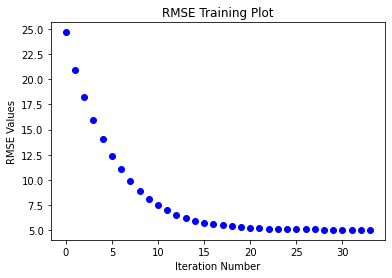

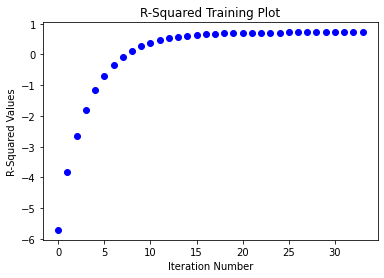

In [20]:
def linearRegression(originalData, target, learningRate, tolerance):
    # prevent changes to original data
    data = originalData.copy()

    # shuffle data
    dataShuffled = data.sample(frac=1).reset_index(drop=True)
    
    numRows = len(dataShuffled)
    oneThirdRows = round(numRows / 3)

    # split data
    testData = dataShuffled[0 : oneThirdRows]
    trainData = dataShuffled.drop(dataShuffled.index[0 : oneThirdRows])

    # normalize data
    normTrainData, normParams, _ = zScoreNormalization(trainData, target)
    normTestData, _, _ = zScoreNormalization(testData, target, normParams=normParams)

    #calculate weights
    weightsMatrix, RMSEList, rSqrList = gradientDescent(normTrainData, target, learningRate, tolerance)
    print("Weights for normalized data using Gradient Descent:")
    print(weightsMatrix)

    trainSSE = calculateSSE(normTrainData, target, weightsMatrix)
    trainRMSE = math.sqrt(trainSSE / len(normTrainData))
    print('Training RMSE:', trainRMSE)

    testSSE = calculateSSE(normTestData, target, weightsMatrix)
    testRMSE = math.sqrt(testSSE / len(normTestData))
    print('Testing RMSE:', testRMSE)


    trainRsq = calculateRSqrd(normTrainData, target, weightsMatrix)
    testRsq = calculateRSqrd(normTestData, target, weightsMatrix)
    print("Train R-squared:", trainRsq)
    print("Test R-squared:", testRsq)

    # plot RMSE over iteration
    title = "RMSE Training Plot"
    plt.plot(RMSEList, 'bo')
    plt.title(title)
    plt.ylabel("RMSE Values")
    plt.xlabel("Iteration Number")
    plt.show()

    # plot R-Squared over iteration
    title = "R-Squared Training Plot"
    plt.plot(rSqrList, 'bo')
    plt.title(title)
    plt.ylabel("R-Squared Values")
    plt.xlabel("Iteration Number")
    plt.show()

# set learning rate and tolerance for gradient descent
learningRate = 0.0004
tolerance = 0.005
linearRegression(housingData, target, learningRate, tolerance)    

# Linear Regression with Regularization
After implementing regularization using L2-norm (aka ridge-regression) it appears that it did not make any significant difference to out model. We got almost the exact same weights, and R-Squared value of ~0.74 .

Because there was almost no change in the results when including the use of regularization, I will try using 2nd-degree polynomial regression (using polynomial kernel with linear regression) and seeing if that improves the error and R-squared scores for test and training data in the next model attempt.



Weights for normalized data using Gradient Descent with Regularization:
[[ 2.26366887e+01]
 [-8.04362464e-01]
 [ 7.84202508e-01]
 [-3.53061060e-01]
 [ 6.37272896e-01]
 [-1.18228978e+00]
 [ 3.56458660e+00]
 [ 3.97442322e-03]
 [-2.23701027e+00]
 [ 1.10629075e+00]
 [-5.35471853e-01]
 [-1.77444860e+00]
 [ 1.01423443e+00]
 [-3.25975432e+00]]
Training RMSE: 4.978615790156603
Testing RMSE: 4.352787510788609
Train R-squared: 0.7232128395355346
Test R-squared: 0.7405336616900029


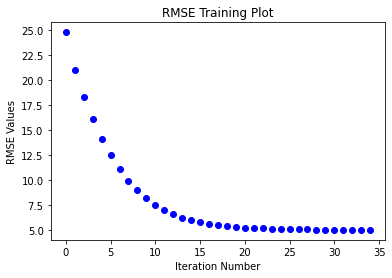

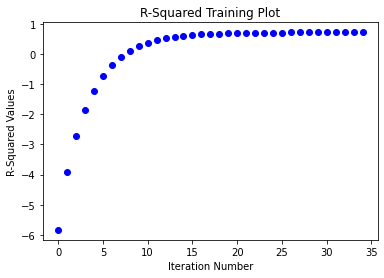

In [22]:
def linearRegressionRegularized(originalData, target, learningRate, tolerance):
    # prevent changes to original data
    data = originalData.copy()

    # shuffle data
    dataShuffled = data.sample(frac=1).reset_index(drop=True)
    
    numRows = len(dataShuffled)
    oneThirdRows = round(numRows / 3)

    testData = dataShuffled[0 : oneThirdRows]
    trainData = dataShuffled.drop(dataShuffled.index[0 : oneThirdRows])

    normTrainData, normParams, _ = zScoreNormalization(trainData, target)
    normTestData, _, _ = zScoreNormalization(testData, target, normParams=normParams)

    weightsMatrix, RMSEList, rSqrList = gradientDescentRegularized(normTrainData, target, learningRate, tolerance)
    print("Weights for normalized data using Gradient Descent with Regularization:")
    print(weightsMatrix)

    trainSSE = calculateSSE(normTrainData, target, weightsMatrix)
    trainRMSE = math.sqrt(trainSSE / len(normTrainData))
    print('Training RMSE:', trainRMSE)

    testSSE = calculateSSE(normTestData, target, weightsMatrix)
    testRMSE = math.sqrt(testSSE / len(normTestData))
    print('Testing RMSE:', testRMSE)


    trainRsq = calculateRSqrd(normTrainData, target, weightsMatrix)
    testRsq = calculateRSqrd(normTestData, target, weightsMatrix)
    print("Train R-squared:", trainRsq)
    print("Test R-squared:", testRsq)

    # plot RMSE over iteration
    title = "RMSE Training Plot"
    plt.plot(RMSEList, 'bo')
    plt.title(title)
    plt.ylabel("RMSE Values")
    plt.xlabel("Iteration Number")
    plt.show()

    # plot R-Squared over iteration
    title = "R-Squared Training Plot"
    plt.plot(rSqrList, 'bo')
    plt.title(title)
    plt.ylabel("R-Squared Values")
    plt.xlabel("Iteration Number")
    plt.show()

# set learning rate and tolerance for gradient descent
learningRate = 0.0004
tolerance = 0.005
linearRegressionRegularized(housingData, target, learningRate, tolerance)  

# With Regularization and Polynomial Kernel
Even after implementing a polynomial kernel in our linear model to possibly increase the R-squared value or decrease the Root Mean Square Error (RMSE), we can see that from our results they are very very similar (within 1%) to the results that we generated with just the linear features. This implementation below also includes normalization and regularization (L2-norm). 

Unfortunately, After seeing this result, I have to conclude that as long as I am using a linear model, it would be unlikely that I would be able to get an R-squared value higher than an average ~0.74 without overfitting to the data.

In [13]:
def getPolynomialData(originalData, target, p):
    '''
    Add new features for each feature of higher powers until x^p. Used for
    Polynomial Regression.
    
    :param originalData: pandas dataframe
    :param target: target column name
    :param p: max polynomial degree value
    
    '''
    data = originalData.copy()

    colNames = getColNames(data)

    targetCol = data[target]

    newData = pd.DataFrame()

    for col in colNames:
        if col == target:
            continue
        uniques = list(data[col].unique())
        if len(uniques) == 1:
            newData = pd.concat([newData.reset_index(drop=True), data[col].reset_index(drop=True)], axis=1)
            continue
        colExps = pd.DataFrame()

        for i in range(1, p + 1):
            colExps[i] = data[col].pow(i)

        newData = pd.concat([newData.reset_index(drop=True), colExps.reset_index(drop=True)], axis=1)

    newData = pd.concat([newData.reset_index(drop=True), targetCol.reset_index(drop=True)], axis=1)

    colNames = getColNames(newData)
    newColNames = []
    for i in range(len(colNames)):
        newColNames.append(str(i))
    colNames = newColNames
    target = colNames[-1]

    newData.columns = colNames

    return newData, target

Weights for normalized data using Gradient Descent with Regularization:
[[ 2.25300962e+01]
 [-4.61472744e-01]
 [-4.53843544e-01]
 [ 4.15329012e-01]
 [ 8.64191602e-01]
 [-2.88223919e-01]
 [ 2.94979942e-01]
 [ 3.63518560e-01]
 [ 3.63518560e-01]
 [-1.00147673e+00]
 [-1.24892383e+00]
 [ 4.21949045e-01]
 [ 2.15514988e+00]
 [-1.03377009e-02]
 [ 3.45446804e-01]
 [-2.08832185e+00]
 [-1.10568297e+00]
 [ 1.07757937e+00]
 [ 7.85284084e-01]
 [-9.48745554e-01]
 [-3.40390412e-01]
 [-1.20812896e+00]
 [-1.07836661e+00]
 [ 6.85503642e-01]
 [ 1.99238560e-01]
 [-3.79588512e+00]
 [ 9.64801844e-02]]
Training RMSE: 4.741223880896391
Testing RMSE: 4.442413466579261
Train R-squared: 0.7413691825361506
Test R-squared: 0.7499057537568103


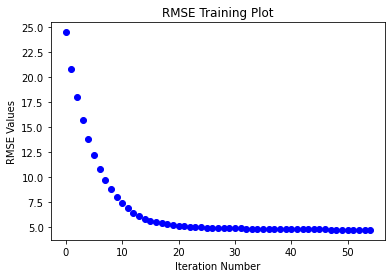

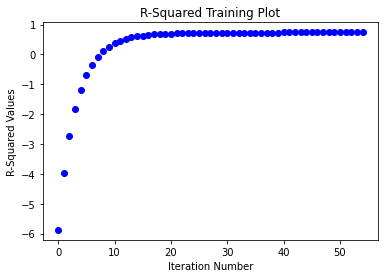

In [15]:
def linearRegressionWithSecondDegreePolynomialFeatures(originalData, target, learningRate, tolerance):
    # prevent changes to original data
    data = originalData.copy()

    # shuffle data
    dataShuffled = data.sample(frac=1).reset_index(drop=True)

    numRows = len(dataShuffled)
    oneThirdRows = round(numRows / 3)

    testData = dataShuffled[0 : oneThirdRows]
    trainData = dataShuffled.drop(dataShuffled.index[0 : oneThirdRows])

    # make dataset polynomial to the power of 2
    expTrainData, newTarget = getPolynomialData(trainData, target, 2)
    expTestData, _ = getPolynomialData(testData, target, 2)
    target = newTarget

    normTrainData, normParams, _ = zScoreNormalization(expTrainData, target)
    normTestData, _, _ = zScoreNormalization(expTestData, target, normParams=normParams)

    weightsMatrix, RMSEList, rSqrList = gradientDescentRegularized(normTrainData, target, learningRate, tolerance)
    print("Weights for normalized data using Gradient Descent with Regularization:")
    print(weightsMatrix)

    trainSSE = calculateSSE(normTrainData, target, weightsMatrix)
    trainRMSE = math.sqrt(trainSSE / len(normTrainData))
    print('Training RMSE:', trainRMSE)

    testSSE = calculateSSE(normTestData, target, weightsMatrix)
    testRMSE = math.sqrt(testSSE / len(normTestData))
    print('Testing RMSE:', testRMSE)


    trainRsq = calculateRSqrd(normTrainData, target, weightsMatrix)
    testRsq = calculateRSqrd(normTestData, target, weightsMatrix)
    print("Train R-squared:", trainRsq)
    print("Test R-squared:", testRsq)

    # plot RMSE over iteration
    title = "RMSE Training Plot"
    plt.plot(RMSEList, 'bo')
    plt.title(title)
    plt.ylabel("RMSE Values")
    plt.xlabel("Iteration Number")
    plt.show()

    # plot R-Squared over iteration
    title = "R-Squared Training Plot"
    plt.plot(rSqrList, 'bo')
    plt.title(title)
    plt.ylabel("R-Squared Values")
    plt.xlabel("Iteration Number")
    plt.show()

# set learning rate and tolerance for gradient descent
learningRate = 0.0004
tolerance = 0.005
linearRegressionWithSecondDegreePolynomialFeatures(housingData, target, learningRate, tolerance)  